In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as nn_init
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader

In [3]:
import sys
sys.path.append("..")
from mibi.preprocess.mibi_image import *
from mibi.preprocess.mibi_plot import *
from mibi.nets.bgsub.dataset_regression import BackgroundSubtractionRegressionDataset
from mibi.nets.bgsub.network import BGSubtractRegression

In [4]:
data_dir = '/Users/mschachter/data/CHOP_TMA_pilot_2'
images_dir = os.path.join(data_dir, 'extracted')
channels_data_path = os.path.join(data_dir, 'info', 'panel.csv')

In [5]:
ds = BackgroundSubtractionRegressionDataset(images_dir, channels_data_path)

Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point4
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point3
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point2
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point5
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point11
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point16
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point29
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point20
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point27
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point18
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point26
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point19
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point21
Loading from /Users/mschachter/data/CHOP_TMA_pilot_2/extracted/Point17
Loading fr

In [6]:
ds[0].shape

torch.Size([1024, 1024, 19])

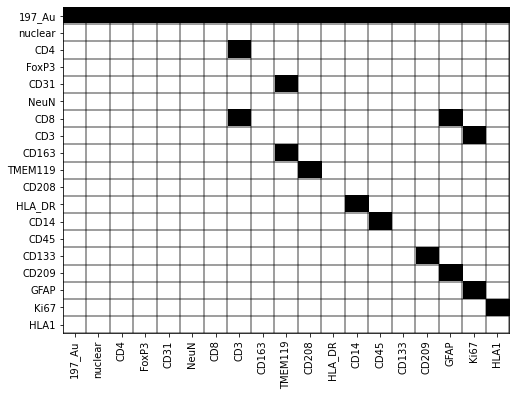

In [7]:
fig = plt.figure(figsize=(8, 6))
plt.imshow(ds.M.detach().numpy(), interpolation='nearest', aspect='auto', cmap=plt.cm.bone_r);
plt.xticks(range(len(ds.chan_indices)), ds.chan_names, rotation=90);
plt.yticks(range(len(ds.chan_indices)), ds.chan_names);
for k in range(len(ds.chan_indices)):
    plt.axhline(k+0.5, c='k', alpha=0.5)
    plt.axvline(k+0.5, c='k', alpha=0.5)

In [8]:
param_file = '../default_network.pytorch.zip'
net = BGSubtractRegression.load_from_file(param_file, ds.M)

In [16]:
W = net.get_comp_matrix()
np.savetxt('comp_matrix.csv', W, delimiter=',', fmt='%0.6f')
with open('comp_matrix_channels.csv', 'w') as f:
    f.write(','.join(ds.chan_names))

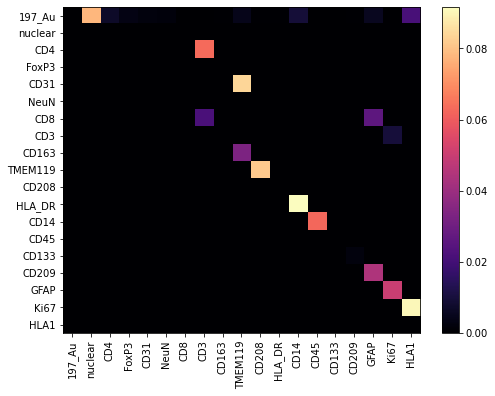

In [17]:
Wviz = W.copy()
Wviz[0, 0] = 0
fig = plt.figure(figsize=(8, 6))
plt.imshow(Wviz, interpolation='nearest', aspect='auto', cmap=plt.cm.magma)
plt.xticks(range(len(ds.chan_indices)), ds.chan_names, rotation=90);
plt.yticks(range(len(ds.chan_indices)), ds.chan_names);
plt.colorbar();

In [14]:
mp_images = dict()
for row_idx,row in ds.df.iterrows():
    fov = row['fov']
    img_bgsub = net(ds[row_idx])
    img_bgsub.shape
    print('Loading FOV: ', fov)
    mp_image = MIBIMultiplexImage.load_from_path(os.path.join(images_dir, fov, 'TIFs'),
                                                 channels_data_path)
    mp_image.X['bgsub'] = dict()
    
    B = net(ds[row_idx])
    for k,chan_idx in enumerate(ds.chan_indices):
        Xbgsub = mp_image.X['raw'][chan_idx] - B[:, :, k].detach().numpy()
        mp_image.X['bgsub'][chan_idx] = Xbgsub

    mp_images[fov] = mp_image

Loading FOV:  Point4
Loading FOV:  Point3
Loading FOV:  Point2
Loading FOV:  Point5
Loading FOV:  Point11
Loading FOV:  Point16
Loading FOV:  Point29
Loading FOV:  Point20
Loading FOV:  Point27
Loading FOV:  Point18
Loading FOV:  Point26
Loading FOV:  Point19
Loading FOV:  Point21
Loading FOV:  Point17
Loading FOV:  Point28
Loading FOV:  Point10
Loading FOV:  Point30
Loading FOV:  Point7
Loading FOV:  Point9
Loading FOV:  Point8
Loading FOV:  Point6
Loading FOV:  Point1
Loading FOV:  Point15
Loading FOV:  Point12
Loading FOV:  Point24
Loading FOV:  Point23
Loading FOV:  Point22
Loading FOV:  Point25
Loading FOV:  Point13
Loading FOV:  Point14


In [18]:
#plot_mibi_image(mp_images['Point4'], transform=True, saturate_percentile=99,
#                plot_height=6, plot_width=8,
#                transforms_to_show=['raw', 'bgsub'],
#                output_file='Point4_bgsub.png')